In [6]:
import numpy as np
import pandas as pd
import os
import sys
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import exposure
from skimage import transform
import warnings
from tqdm.notebook import tqdm
import imageio

import cv2

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

GRAY_SCALE = 1

# Some constants
HIP_THRESHOLD = [0.3, 0.4]
NECK_THRESHOLD = 0.2
LUNG_THRESHOLD = 0.7
OUTPUT_DIM = 1024

dataset_dir = '../input/vinbigdata-chest-xray-abnormalities-detection/'

# Read dicom images into numpy array (https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way)
def read_xray(path, voi_lut=True, monochrome=True, normalize=True):
    dicom = pydicom.read_file(path)

    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    if monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    if normalize:
        data = exposure.equalize_hist(data)
        
    data = data - np.min(data)
    data = data / np.max(data)

    return data

In [2]:
# Calculate the margin of the chest
def calculate_margins(data):
    height = data.shape[0]
    width = data.shape[1]

    # Get the median brighness value along with x and y axis
    x_scale = np.median(data, axis=1)
    y_scale = np.median(data, axis=0)

    # Initialise default margin value [top, bottom, left, right]
    margins = [0, height, 0, width]

    # Calculate the left margin
    if y_scale[0] < HIP_THRESHOLD[0]:
        for i in range(width // 3):
            if y_scale[i] < HIP_THRESHOLD[1] * GRAY_SCALE < y_scale[i + 1]:
                margins[2] = i
                break

    # Calculate the left margin 
    if y_scale[-1] < HIP_THRESHOLD[0]:
        for i in range(width - 1, width // 3 * 2, -1):
            if y_scale[i] < HIP_THRESHOLD[1] * GRAY_SCALE < y_scale[i - 1]:
                margins[3] = i
                break
    
    # Calculate the top magin, looping until the median brighness reach the neck threshold
    for i in range((margins[3]-margins[2]) // 2):
            if x_scale[i] < NECK_THRESHOLD * GRAY_SCALE < x_scale[i + 1]:
                margins[0] = i
                break
   
    # Crop out the left hip and right hip to get the middle part
    middle_part = data[:, margins[2]:margins[3]]
    
    # Initialise the bottom margin for left lung and right lung
    margin_bottom_left = margins[0]
    margin_bottom_right = margins[0]

    # Crop out the lungs
    left_lung = middle_part[:, (margins[3]-margins[2])//6:(margins[3]-margins[2])//6*3]
    right_lung = middle_part[:, (margins[3]-margins[2])//6*3:(margins[3]-margins[2])//6*5]
    
    # Normalise the brightneess
    left_lung = exposure.equalize_hist(left_lung)
    right_lung = exposure.equalize_hist(right_lung)
    
    # Calculate the median brightness
    x_scale_left = np.median(left_lung, axis=1)
    x_scale_right = np.median(right_lung, axis=1)

    # Calculate the margin based on the brightness of the left lung
    for i in range(margins[0]+(margins[3]-margins[2])//2, height - 1):
        if x_scale_left[i] < LUNG_THRESHOLD * GRAY_SCALE < x_scale_left[i + 1]:
            margin_bottom_left = i
            break

    # Calculate the margin based on the brightness of the right lung
    for i in range(margins[0]+(margins[3]-margins[2])//2, height - 1):
        if x_scale_right[i] < LUNG_THRESHOLD * GRAY_SCALE < x_scale_right[i + 1]:
            margin_bottom_right = i
            break

    # Set the bottom margin max of left lung and right lung
    margins[1] = max(margin_bottom_left, margin_bottom_right)
    # If the bottom margin is higher than the height of square then scrop at the part that make the image a square
    margins[1] = max(margins[1], margins[0] + (margins[3] - margins[2]))
    # if the square is higher than the original image then margin bottom is set to height of the original image
    margins[1] = min(margins[1], height)

    # Crop out the chest
    cropped = middle_part[margins[0]:margins[1], :]
    # Normalise the image last time    
    cropped = exposure.equalize_hist(cropped)

    
    return margins, cropped

In [3]:
def show_xray_data_cropped(image_id, data, cropped):
    fig=plt.figure(figsize=(15, 3))
    fig.suptitle(image_id, y=0)
    
    fig.add_subplot(1, 4, 1) 
    plt.imshow(data, cmap=plt.cm.bone)
    plt.title('Original')
 
    fig.add_subplot(1, 4, 2)
    plt.imshow(cropped, cmap=plt.cm.bone)
    plt.title('Cropped')
    
    fig.add_subplot(1, 4, 3)
    plt.title('Brightness Scale by X')
    plt.ylim([0, GRAY_SCALE])
    plt.plot(np.median(data, axis=1))
    plt.plot(data.mean(1))
    
    fig.add_subplot(1, 4, 4)
    plt.title('Brightness Scale by Y')
    plt.ylim([0, GRAY_SCALE])
    plt.plot(np.median(data, axis=0))
    plt.plot(data.mean(0))
    
    plt.show()

['1c32170b4af4ce1a3030eb8167753b06' 'e7e8948818352b4d800dfac9a8999300'
 '53e2a10eb9969b0e336a51d11dda17f9' ... '9b294ef55b60d28d047089d91a1ca502'
 '30d24189cf005a9baf02929afd518832' '52979eadb9adb0c1dc9a64fa0d3c4d26']


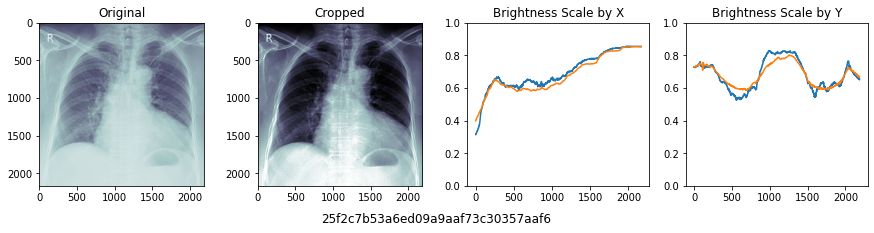

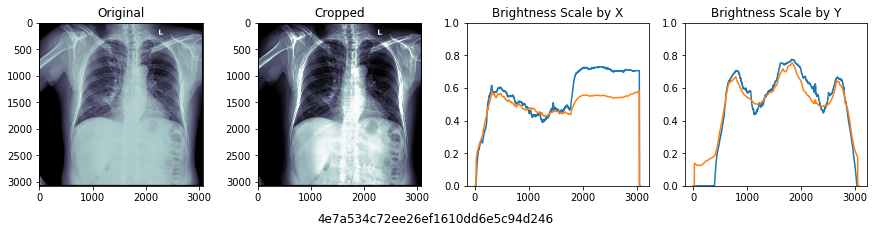

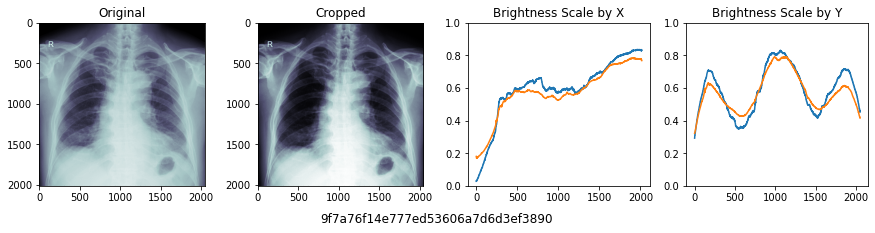

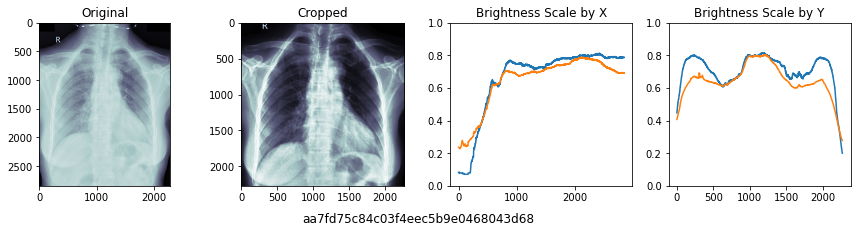

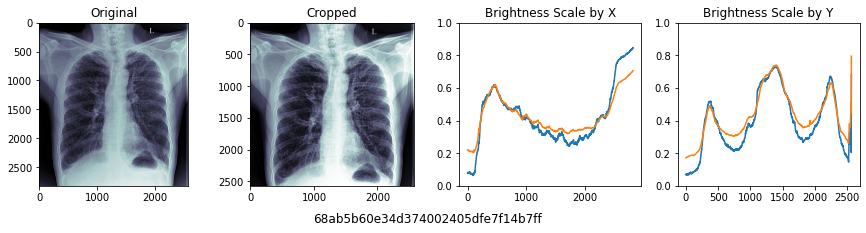

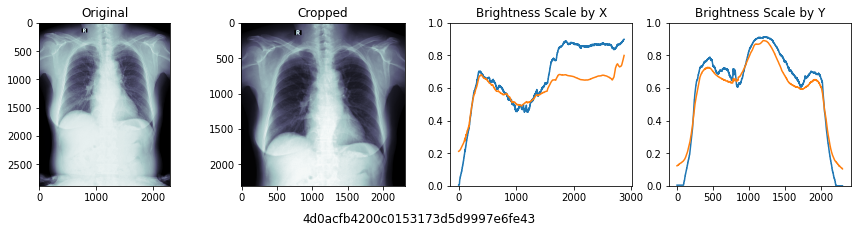

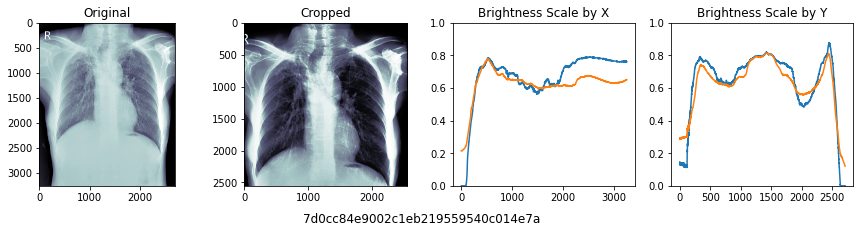

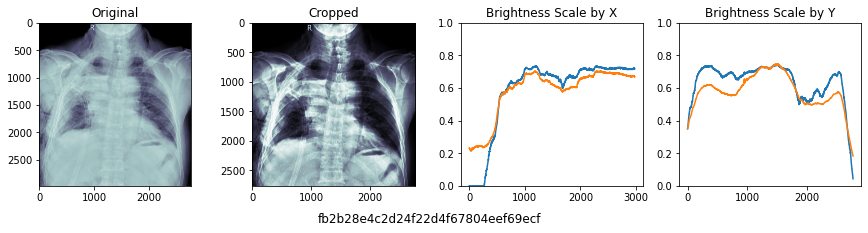

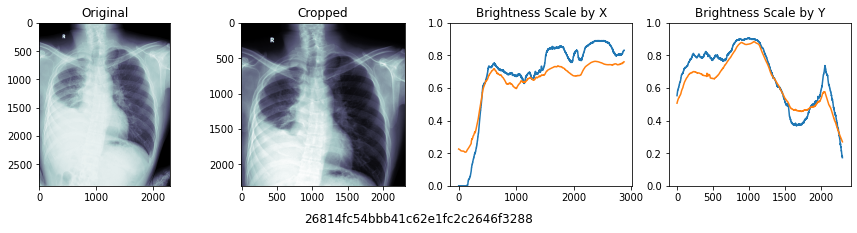

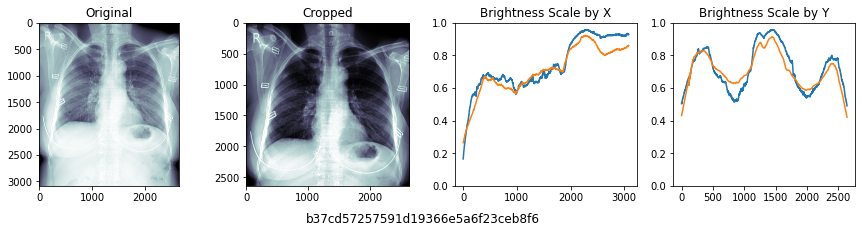

In [9]:
df = pd.read_csv('/home/hana/sonnh/kaggle-vin/dataset/images_only/train_only_box_merge_box.csv')
df = df[df['class_id'] != 14]
image_ids = df['image_id'].unique()
print(image_ids)
samples = []
samples.extend(np.random.choice(image_ids, 10))

folder_image = '/home/hana/sonnh/kaggle-vin/dataset/images_only/train'

for image_id in samples:
#     data = read_xray(os.path.join(dataset_dir, 'train', image_id + '.dicom'))
    data = cv2.imread('{}/{}.dicom.png'.format(folder_image, image_id), 0)
    data = data/255.0
    margins, cropped = calculate_margins(data)
    show_xray_data_cropped(image_id, data, cropped)
    

In [ ]:
def shift_bboxes():
    
    train = pd.read_csv(os.path.join(dataset_dir, 'train.csv'))
    cropped = pd.read_csv('../input/vinbigdata-xray-cropped-512/train.cropped.csv', index_col='image_id')
    train = pd.merge(train, cropped, on='image_id', how='left')

    print(train)

    train['x_min'] = train['x_min'] - train['left']
    train['x_max'] = train['x_max'] - train['left']

    train['y_min'] = train['y_min'] - train['top']
    train['y_max'] = train['y_max'] - train['top']

    train['x_min'] = train.apply(lambda row: 0 if row.x_min < 0 else row.x_min, axis=1)
    train['y_min'] = train.apply(lambda row: 0 if row.y_min < 0 else row.y_min, axis=1)

    train['x_max'] = train.apply(lambda row: row.right - row.left if row.x_max > row.right - row.left else row.x_max, axis=1)
    train['y_max'] = train.apply(lambda row: row.bottom - row.top if row.y_max > row.bottom - row.top else row.y_max, axis=1)

    print(train)
    train.to_csv('train.shifted.csv', index=None)